In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

print('Версия pandas:', pd.__version__)

Версия pandas: 2.1.4


# Сводные таблицы в pandas.

## Часть 2. Фрагмент 2. 

    - Pivot & Pivot_table - вспоминаем основные различия
    - Открываем файл girls_purchases
    - Типичная ошибка в использовании pivot_table
    - Варианты решения и преобразование структуры DataFrame
    - Метод melt & pd.wide_to_long
    

## Pivot & Pivot_table - вспоминаем основные различия

    1. DataFrame.pivot() или pd.pivot() 
    создает сводную таблицу общего назначения с различными типами данных
    
    2. DataFrame.pivot_table() или pd.pivot_table() 
    используется для создания для сводной таблицы с агрегированием числовых данных
    (можно использовать для создания сводных таблиц в стиле электронных таблиц Excel)

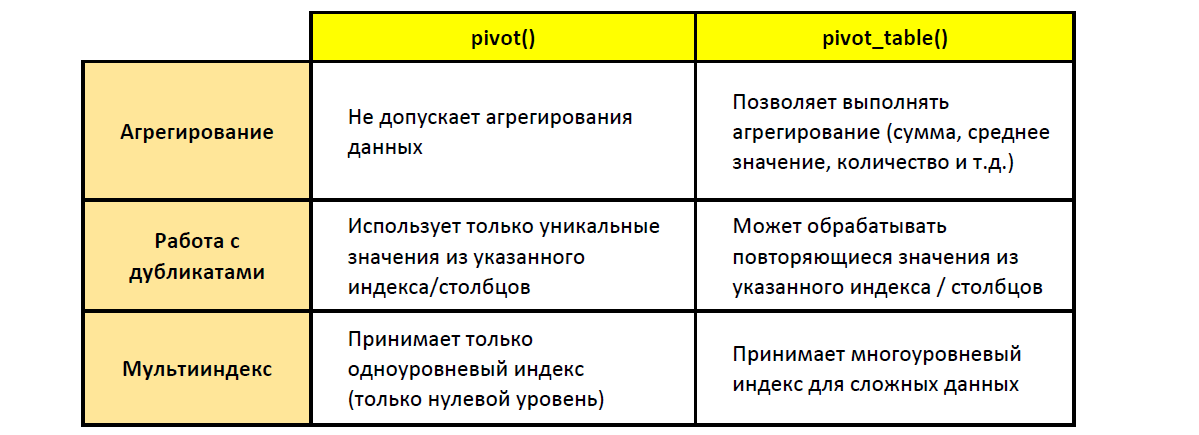

In [2]:
Image('files/pivot_vs_pivot_table.png')

## Открываем файл girls_purchases

In [4]:
# заранее задаем тип данных для категориальных столбцов через словарь в переменной dtypes_cat
# при открытии файла передаем словарь в параметр dtype

dtypes_cat = {'season':'category', 'brand':'category'}

df_p = pd.read_csv('files/girls_purchases', dtype=dtypes_cat)
df_p.info()
df_p

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Name         12 non-null     object  
 1   season       12 non-null     category
 2   brand        12 non-null     category
 3   clothes      12 non-null     int64   
 4   shoes        12 non-null     int64   
 5   accessories  12 non-null     int64   
dtypes: category(2), int64(3), object(1)
memory usage: 572.0+ bytes


,Name,season,brand,clothes,shoes,accessories
0,Helen,autumn & winter,no,2,1,1
1,Helen,autumn & winter,yes,2,1,2
2,Helen,spring & summer,no,2,3,4
3,Helen,spring & summer,yes,2,4,4
4,Tracey,autumn & winter,no,2,4,1
5,Tracey,autumn & winter,yes,2,2,3
6,Tracey,spring & summer,no,1,2,3
7,Tracey,spring & summer,yes,3,4,1
8,Jennifer,autumn & winter,no,3,4,4
9,Jennifer,autumn & winter,yes,3,1,3


## Пример 3.1.1

    Задача
    
   _Необходимо узнать, сколько всего элементов одежды купила каждая из девушек за весь период и в каждом сезоне отдельно
    (нам не важно, брендовая это одежда или обычная). 
    Также мы хотим взглянуть, в каком сезоне (осенне-зимнем или весенне-летнем) девушки приобрели больше предметов одежды._
    
    - В  index ставим имена девушек, в columns ставим 'сезон' 
    (или, наоборот, если поставили в index 'сезон', то в columns ставим 'Name')
    - В values передаем колонку 'clothes', если передадим название в квадратных скобках - получим иерархический индекс
    Можем передать просто values='clothes', тогда на выходе не увидим слова 'clothes' в индексе столбцов
    - в параметр aggfunc передаем название агрегирующей функции sum'
    - в margins передаем True. т.к. нам нужны итоговые показатели по каждой девушке и по каждому сезону

In [5]:
# варианты синтаксиса: values = ['clothes'] & values='clothes'

display(df_p.pivot_table(index='Name', columns='season', values=['clothes'], 
                 aggfunc='sum', margins=True),
        
        # другая форма результата
        df_p.pivot_table(index='season', columns='Name', values=['clothes'], 
                 aggfunc='sum', margins=True))

clothes                    
season   autumn & winter spring & summer All
Name                                        
Helen                  4               4   8
Jennifer               6               4  10
Tracey                 4               4   8
All                   14              12  26

clothes                    
Name              Helen Jennifer Tracey All
season                                     
autumn & winter       4        6      4  14
spring & summer       4        4      4  12
All                   8       10      8  26

## Пример 3.1.2

#### Обращаем внимание на параметр values

    В values мы передали название колонки 'clothes' в квадратных скобках (values=['clothes']),
    В результирующей структуре в колонках образовался MultiIndex
    
    Если передадим название колонки 'clothes' без квадратных скобок (values='clothes'), 
    то в результате получим не MultiIndex, а обычный объект Index, в котором не будет фигурировать название 'clothes'

In [6]:
display(df_p.pivot_table(index='Name', values=['clothes'], columns='season',
                 aggfunc='sum', margins=True))

df_p.pivot_table(index='Name', values=['clothes'], columns='season',
                 aggfunc='sum', margins=True).columns

clothes                    
season   autumn & winter spring & summer All
Name                                        
Helen                  4               4   8
Jennifer               6               4  10
Tracey                 4               4   8
All                   14              12  26

MultiIndex([('clothes', 'autumn & winter'),
            ('clothes', 'spring & summer'),
            ('clothes',             'All')],
           names=[None, 'season'])

In [7]:
# если передаем в values строку 'clothes', то в результате в колонках получаем обычный Index

display(df_p.pivot_table(index='Name', values='clothes', columns='season',
                 aggfunc='sum', margins=True),
        df_p.pivot_table(index='Name', values='clothes', columns='season',
                 aggfunc='sum', margins=True).columns)

season,autumn & winter,spring & summer,All
Name,,,
Helen,4,4,8
Jennifer,6,4,10
Tracey,4,4,8
All,14,12,26


Index(['autumn & winter', 'spring & summer', 'All'], dtype='object', name='season')

## Пример 3.2

Задача
    
   _Необходимо узнать, сколько всего элементов одежды купила каждая из девушек 
   (не учитываем бренд и сезон, и общее количество элементов одежды нам также не нужно)_
    
    - В  index ставим имена девушек, в columns ничего не передаем 
    - В values передаем колонку 'clothes'
    - в параметр aggfunc передаем название агрегирующей функции sum'
    - в margins оставляем по умолчанию в позиции False. т.к. нам не нужны итоговые показатели

In [8]:
# не передаем аргумент columns
# передаем одну колонку в values: values='clothes' (или values=['clothes'])

display(df_p.pivot_table(index='Name', values='clothes', aggfunc='sum'))

# того же результата мы можем добиться, использовав метод grpoupby

display(df_p.groupby('Name')[['clothes']].agg('sum'))

,clothes
Name,
Helen,8
Jennifer,10
Tracey,8


,clothes
Name,
Helen,8
Jennifer,10
Tracey,8


## Пример 3.3.1

    Задача
    
   _Необходимо узнать, сколько в сумме элементов отдельно по каждой категории (одежда, обувь, аксессуары) купила каждая девушка. Мы не учитываем бренд и сезон, но общее количество элементов каждой категории покупки нам НУЖНО_
    
    - В  index ставим колонку с именами 'Name', в columns ничего не передаем 
    - В values передаем в списке названия колонок ['clothes', 'shoes', 'accessories']
    - в параметр aggfunc передаем название агрегирующей функции sum'
    - margins переводим в True. т.к. нам нужны итоговые показатели по каждой категории покупки

In [9]:
# не передаем аргумент columns
# передаем несколько колонок в values: values=['clothes', 'shoes', 'accessories']
# в результате только горизонтальный промежуточный итог All

df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], aggfunc='sum', margins=True)


,accessories,clothes,shoes
Name,,,
Helen,11,8,9
Jennifer,11,10,12
Tracey,8,8,12
All,30,26,33


## Типичная ошибка использования pivot_table

    синтаксис:
    df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], aggfunc='sum', margins=True)
    
_ОШИБКА ожидать в результирующей структуре столбик c меткой All, содержащий общее количество покупок, совершенных каждой отдельной девушкой._

In [10]:
df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], aggfunc='sum', margins=True)

,accessories,clothes,shoes
Name,,,
Helen,11,8,9
Jennifer,11,10,12
Tracey,8,8,12
All,30,26,33


In [11]:
df_p.head()

,Name,season,brand,clothes,shoes,accessories
0,Helen,autumn & winter,no,2,1,1
1,Helen,autumn & winter,yes,2,1,2
2,Helen,spring & summer,no,2,3,4
3,Helen,spring & summer,yes,2,4,4
4,Tracey,autumn & winter,no,2,4,1


## Пример 3.3.2

In [12]:
# получаем итоги, расщепленные по сезонам и категория покупок
# общего количества покупок по каждой девушке мы таким образом не получим

df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], columns='season',
                 aggfunc='sum', margins=True)

accessories                             clothes                  \
season   autumn & winter spring & summer All autumn & winter spring & summer   
Name                                                                           
Helen                  3               8  11               4               4   
Jennifer               7               4  11               6               4   
Tracey                 4               4   8               4               4   
All                   14              16  30              14              12   

                       shoes                      
season   All autumn & winter spring & summer All  
Name                                              
Helen      8               2               7   9  
Jennifer  10               5               7  12  
Tracey     8               6               6  12  
All       26              13              20  33

### Задача: создать сводную таблицу, в которой будут следующие данные... 
- общее количество покупок по каждой категории (одежда, обувь, аксессуары) 
- общее количество покупок каждой девушки

Варианты решения

    Вариант 1. Добавить итоги вручную (без использования pivot_table)
    Вариант 2. Получить данные для анализа в другой форме, далее - использовать pivot_table.
    Вариант 3. Привести имеющийся DataFrame к той форме, 
    которая даст возможность добавить колонку All с помощью pivot_table. 
    Для реализации Варианта 3 будем использовать .stack() или .melt(),

In [13]:
display(df_p.head(2))
display(df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], aggfunc='sum', margins=True))

,Name,season,brand,clothes,shoes,accessories
0,Helen,autumn & winter,no,2,1,1
1,Helen,autumn & winter,yes,2,1,2


,accessories,clothes,shoes
Name,,,
Helen,11,8,9
Jennifer,11,10,12
Tracey,8,8,12
All,30,26,33


## Пример 3.3.3

## Вариант 1

    Добавляем итоги вручную
    
    1-й шаг - Используем pivot_table с параметром margins=True
    2-й шаг - Добавляем колонку с итогами, используя функцию sum(axis=1)

In [14]:
res=df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], aggfunc='sum', margins=True)
display(res)

res['Total']=res.sum(axis=1)
display(res)

,accessories,clothes,shoes
Name,,,
Helen,11,8,9
Jennifer,11,10,12
Tracey,8,8,12
All,30,26,33


,accessories,clothes,shoes,Total
Name,,,,
Helen,11,8,9,28
Jennifer,11,10,12,33
Tracey,8,8,12,28
All,30,26,33,89


## Вариант 2

    Получаем данные для анализа в другой форме, далее используем pivot_table
    
    1 шаг - Применяем pivot_table к определенному формату таблицы
    
    В новом формате - Категории покупки ('clothes', 'shoes', 'accessories') - это значения колонки 'purchase_type', 
    соответствующие числовые значения располагаются в колонке 'count'

In [15]:
# старый формат
print('старый формат')
display(df_p.head(3))

# новый формат
# раньше категории покупки - это названия колонок
# теперь категории покупки - это значения колонки 'purchase_type', соответствующие числовые значения теперь - в колонке 'count'

df_p_2 = pd.read_excel('files/girls_purchases_excel.xlsx')
print('новый формат')
display(df_p_2.head(3))

# применение pivot_table к новому формату
display(df_p_2.pivot_table(index='Name', columns='purchase_type', values='count', aggfunc='sum', margins=True))

старый формат


,Name,season,brand,clothes,shoes,accessories
0,Helen,autumn & winter,no,2,1,1
1,Helen,autumn & winter,yes,2,1,2
2,Helen,spring & summer,no,2,3,4


новый формат


,Name,season,brand,purchase_type,count
0,Helen,autumn & winter,no,clothes,2
1,Helen,autumn & winter,no,shoes,1
2,Helen,autumn & winter,no,accessories,1


purchase_type,accessories,clothes,shoes,All
Name,,,,
Helen,11,8,9,28
Jennifer,11,10,12,33
Tracey,8,8,12,28
All,30,26,33,89


## Вариант 3.1

    Приводим имеющийся датафрейм к тому формату, 
    который дает возможность добавить колонку 'All' с помощью pivot_table
    
    1-й шаг - Используем .pivot_table() + columns.set_names()
    2-й шаг - Используем .stack() + Series.reset_index(c параметром name='count') 
    3-й шаг - Используем .pivot_table()  

#### 1 шаг 
#### Используем .pivot_table() + columns.set_names()

In [16]:
# используем имеющуюся структуру для агрегации данных без итогов
res_2=df_p.pivot_table(index='Name', values=['clothes', 'shoes', 'accessories'], aggfunc='sum')
display(res_2)
# Даем название нулевому уровню индексов столбцов
res_2.columns.set_names('purchase_type', inplace=True)
display(res_2)

,accessories,clothes,shoes
Name,,,
Helen,11,8,9
Jennifer,11,10,12
Tracey,8,8,12


purchase_type,accessories,clothes,shoes
Name,,,
Helen,11,8,9
Jennifer,11,10,12
Tracey,8,8,12


#### 2 шаг
#### Используем .stack() + Series.reset_index()

In [17]:
display(res_2.stack())

# используем pd.Series.reset_index с аргументом name='count', тем самым превращая Series в DataFrame
# имя, переданное в 'name' становится меткой колонки с соответствующими значениями серии, к которой мы применилии reset_index

display(res_2.stack().reset_index(name='count'))

Name      purchase_type
Helen     accessories      11
          clothes           8
          shoes             9
Jennifer  accessories      11
          clothes          10
          shoes            12
Tracey    accessories       8
          clothes           8
          shoes            12
dtype: int64

,Name,purchase_type,count
0,Helen,accessories,11
1,Helen,clothes,8
2,Helen,shoes,9
3,Jennifer,accessories,11
4,Jennifer,clothes,10
5,Jennifer,shoes,12
6,Tracey,accessories,8
7,Tracey,clothes,8
8,Tracey,shoes,12


#### 3 шаг
#### Используем .pivot_table()

In [18]:
display(res_2.stack().reset_index(name='count').pivot_table(index='Name', 
                                                   values='count', 
                                                   columns='purchase_type', 
                                                   aggfunc='sum', margins=True))

purchase_type,accessories,clothes,shoes,All
Name,,,,
Helen,11,8,9,28
Jennifer,11,10,12,33
Tracey,8,8,12,28
All,30,26,33,89


## Вариант 3.2  (используем метод melt)

    Приводим имеющийся DataFrame к тому формату, 
    который дает возможность добавить колонку 'All' с помощью pivot_table
    
    Используем .melt() + .pivot_table()

# Метод Melt (Функция pd.melt)

_Разворачивает DataFrame из широкого формата в длинный, по желанию оставляя идентификаторы.
Эта функция полезна для преобразования DataFrame в формат, в котором один или несколько столбцов являются переменными-идентификаторами (id_vars), а все остальные столбцы, считающиеся измеряемыми переменными (value_vars), «разворачиваются» к оси строк, оставляя только два столбца без идентификаторов, 'variable' и 'value'._

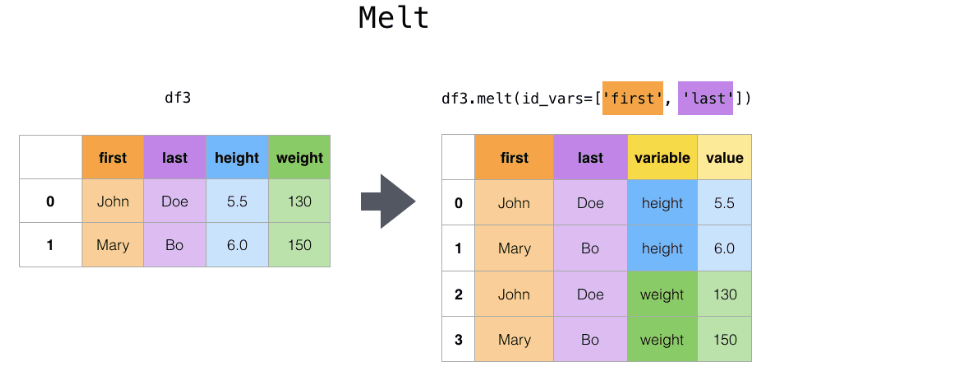

In [3]:
Image('files/melt.png')

    Параметры:

    id_vars - Столбец(ы) для использования в качестве переменных-идентификаторов.
    value_vars - Столбец(и) для разворота. Если не указано, используются все столбцы, которые не заданы как id_vars.
    var_name - Имя, используемое для столбца 'variable'.
    value_name - Имя для столбца 'value'
    col_level - Если столбцы представляют собой мультииндекс, то используется указанный уровень для расплавления.
    ignore_index - Если True, исходный индекс игнорируется. Если False, то исходный индекс сохраняется. 

In [19]:
# старая форма
df_p.head()

,Name,season,brand,clothes,shoes,accessories
0,Helen,autumn & winter,no,2,1,1
1,Helen,autumn & winter,yes,2,1,2
2,Helen,spring & summer,no,2,3,4
3,Helen,spring & summer,yes,2,4,4
4,Tracey,autumn & winter,no,2,4,1


In [20]:
# по умолчанию - variable и value

df_p.melt(id_vars=['Name','season','brand']).head()

,Name,season,brand,variable,value
0,Helen,autumn & winter,no,clothes,2
1,Helen,autumn & winter,yes,clothes,2
2,Helen,spring & summer,no,clothes,2
3,Helen,spring & summer,yes,clothes,2
4,Tracey,autumn & winter,no,clothes,2


In [21]:
# даем имена колонкам var_name='purchase_type', value_name='count'
df_p_new=df_p.melt(id_vars=['Name','season','brand'], var_name='purchase_type', value_name='count')
df_p_new.head()

,Name,season,brand,purchase_type,count
0,Helen,autumn & winter,no,clothes,2
1,Helen,autumn & winter,yes,clothes,2
2,Helen,spring & summer,no,clothes,2
3,Helen,spring & summer,yes,clothes,2
4,Tracey,autumn & winter,no,clothes,2


In [22]:
# применяем pivot_table к 'правильной' форме таблицы
df_p_new.pivot_table(index='Name', values='count', columns='purchase_type', aggfunc='sum', margins=True)

purchase_type,accessories,clothes,shoes,All
Name,,,,
Helen,11,8,9,28
Jennifer,11,10,12,33
Tracey,8,8,12,28
All,30,26,33,89


## Использование melt c MultiIndex

In [23]:
# открываем еще один файл с покупками других трех девушек
# структура с иерархическим индексом строк и столбцов
df_p_2=pd.read_csv('files/girls_purchases_2', index_col=[0,1], header=[0,1])
df_p_2

purchase_type          clothes    shoes    accessories   
brand                      yes no   yes no         yes no
Name   season                                            
Cathy  autumn & winter       1  2     4  3           2  1
       spring & summer       3  2     3  3           1  3
Ann    autumn & winter       3  4     2  4           1  4
       spring & summer       2  1     4  3           3  3
Melony autumn & winter       1  3     3  4           4  2
       spring & summer       1  1     4  4           1  3

In [24]:
# используем для поворота уровень 0
# сохраняем исходный индекс
# название уровня purchase_type становится названием столбца

df_p_2.melt(col_level=0, ignore_index=False).head()

purchase_type  value
Name   season                              
Cathy  autumn & winter       clothes      1
       spring & summer       clothes      3
Ann    autumn & winter       clothes      3
       spring & summer       clothes      2
Melony autumn & winter       clothes      1

In [25]:
# используем для поворота уровень 1 ('brand')
# сохраняем исходный индекс
# название уровня brand становится названием столбца

df_p_2.melt(col_level='brand', ignore_index=False).head()

brand  value
Name   season                      
Cathy  autumn & winter   yes      1
       spring & summer   yes      3
Ann    autumn & winter   yes      3
       spring & summer   yes      2
Melony autumn & winter   yes      1

In [26]:
df_p_2.melt(col_level=1).head()

,brand,value
0,yes,1
1,yes,3
2,yes,3
3,yes,2
4,yes,1


In [27]:
# переносим названия колонок первого уровня, исходный индекс игнорируется 
# даем имя 'count' числовому столбцу value
# применяем группировку по brand с агрегирующей функцией sum

df_p_2.melt(col_level=1, value_name='count').groupby('brand').sum()

,count
brand,
no,50
yes,43


In [28]:
# разворачиваем оба уровня столбцов, создав серию
# применяем группировку по brand с агрегирующей функцией sum

df_p_2.stack(level=[0,1]).groupby('brand').sum()

brand
no     50
yes    43
dtype: int64

## Функция pd.wide_to_long 
#### разворачивает DataFrame из 'широкого' формата в 'длинный'

    Параметры:
    df - структура DataFrame
    stubnames - часть(и) имени(имён) столбца(ов) (stubname) - для одного или нескольких столбцов
    Предполагается, что имена столбцов в 'широком' формате начинаются с имен stubnames
    i - столбец(ы) для использования в качестве переменной(ых) идентификатора(ов)
    j - то, как вы хотите назвать колонку с отрезанными суффиксами в длинном формате.
    sep - символ, указывающий на разделение имен переменных в "широком" формате, 
    который должен быть удален из "длинного" формата.
    suffix - суффикс (str, по умолчанию '\d+' - захватывает числовые суффиксы)
    
#### - Функция wide_to_long обычно полезна, когда у вас есть однородные названия столбцов (stubname) с разными суффиксами (suffix), например, 

## col_1, col_2, col_3. 
     stubname - col
     suffix - 1, 2, 3
     sep - "_"
#### - Функция wide_to_long автоматически извлекает суффиксы и оставляет в названии колонки нового датафрейма только указанное имя или несколько имен, переданных в параметр stubname. По умолчанию метод захватывает числовые суффиксы (1,2,3). Далее эти суффиксы отправляются в значения новой колонки, имя этой колонке вы даете через параметр j.
#### - Можно указать точный формат извлекаемого суффикса с помощью регулярных выражений - regex. Регулярное выражение — это строка, задающая шаблон поиска подстрок в тексте. Одному шаблону может соответствовать много разных строчек. По умолчанию задан шаблон для извлечения числа  '\d+'

In [29]:
# Откроем файл с информацией о зарплатах и налогах сотрудников по состоянию на январь 2020 и 2021 года

df_salary=pd.read_csv('files/salary_2020-2021')
df_salary

,id,Сотрудник,Зарплата_янв.2020,НДФЛ_янв.2020,Зарплата_янв.2021,НДФЛ_янв.2021
0,351,Кузнецов Иван Андреевич,80000,10400,100000,13000
1,352,Марфина Ольга Алексеевна,80000,10400,120000,15600
2,353,Петров Максим Викторович,90000,11700,120000,15600
3,354,Янышев Ростислав Романович,90000,11700,120000,15600


In [30]:
display(pd.wide_to_long(df_salary, stubnames=['Зарплата', 'НДФЛ'], 
                        sep='_янв.', i=['id', 'Сотрудник'], j='год'))

Зарплата   НДФЛ
id  Сотрудник                  год                  
351 Кузнецов Иван Андреевич    2020     80000  10400
                               2021    100000  13000
352 Марфина Ольга Алексеевна   2020     80000  10400
                               2021    120000  15600
353 Петров Максим Викторович   2020     90000  11700
                               2021    120000  15600
354 Янышев Ростислав Романович 2020     90000  11700
                               2021    120000  15600

In [31]:
# i=['Сотрудник', 'id']
display(pd.wide_to_long(df_salary, stubnames=['Зарплата', 'НДФЛ'], 
                        sep='_янв.', i=['Сотрудник', 'id'], j='год'))

Зарплата   НДФЛ
Сотрудник                  id  год                  
Кузнецов Иван Андреевич    351 2020     80000  10400
                               2021    100000  13000
Марфина Ольга Алексеевна   352 2020     80000  10400
                               2021    120000  15600
Петров Максим Викторович   353 2020     90000  11700
                               2021    120000  15600
Янышев Ростислав Романович 354 2020     90000  11700
                               2021    120000  15600

In [32]:
# если не укажем название 'Сотрудник' в идентификаторах 'i'

display(pd.wide_to_long(df_salary, stubnames=['Зарплата', 'НДФЛ'], 
                        sep='_янв.', i='id', j='год'))

# если не укажем название 'id' в идентификаторах 'i'

display(pd.wide_to_long(df_salary, stubnames=['Зарплата', 'НДФЛ'], 
                        sep='_янв.', i='Сотрудник', j='год'))

,,Сотрудник,Зарплата,НДФЛ
id,год,,,
351,2020,Кузнецов Иван Андреевич,80000,10400
352,2020,Марфина Ольга Алексеевна,80000,10400
353,2020,Петров Максим Викторович,90000,11700
354,2020,Янышев Ростислав Романович,90000,11700
351,2021,Кузнецов Иван Андреевич,100000,13000
352,2021,Марфина Ольга Алексеевна,120000,15600
353,2021,Петров Максим Викторович,120000,15600
354,2021,Янышев Ростислав Романович,120000,15600


,,id,Зарплата,НДФЛ
Сотрудник,год,,,
Кузнецов Иван Андреевич,2020,351,80000,10400
Марфина Ольга Алексеевна,2020,352,80000,10400
Петров Максим Викторович,2020,353,90000,11700
Янышев Ростислав Романович,2020,354,90000,11700
Кузнецов Иван Андреевич,2021,351,100000,13000
Марфина Ольга Алексеевна,2021,352,120000,15600
Петров Максим Викторович,2021,353,120000,15600
Янышев Ростислав Романович,2021,354,120000,15600


### Далее...
### Часть 2. Фрагмент 3.

    - Таблицы сопряженности и метод crosstab